# Importing Libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as ltb
import category_encoders as ce

# Reading Data:

In [2]:
data = pd.read_csv('training_variants')

In [3]:
print(data.shape)
data.head(4)

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3


In [4]:
# Text data
data2 = pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
print(data2.shape)
data2.head(4)

(3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


In [6]:
# Merging the two datasets on ID:

data_ = pd.merge(data, data2,on='ID', how='left')
data_.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# Null values :

In [7]:
# Checking null values for [Gene]:

idx = data_['Gene'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [8]:
# Checking null values for [Variation]:

idx = data_['Variation'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [9]:
# Checking null values for [TEXT]:

idx = data_['TEXT'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are SOME null values')

There are SOME null values


In [10]:
idx1 = data_[data_.isna().any(axis=1)]
print('The following are the NaN values for TEXT:')
idx1

The following are the NaN values for TEXT:


,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


- since there are only 5 points with NaN values, we could drop these ID's. But, we already have small dataset so we have to find a workaround these nan values instead of throwing them.

In [11]:
# Workaround for nan values of [TEXT]: We include the [Gene] type and [Variation] name in the [TEXT] column

data_.loc[data_['TEXT'].isnull(),'TEXT'] = data_['Gene'] +' '+data_['Variation']

In [12]:
idx3 = data_.isnull().values.any()
if idx3 == False:
    print('There are NO null values in the dataset.')
else:
    print('There are SOME null values')

There are NO null values in the dataset.


In [13]:
data_.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# Splitting Data:

In [14]:
x = data_.drop(["Class"], axis = 1)
y = data_["Class"]

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,stratify = y,random_state = 0)

In [16]:
xy_train = pd.concat([x_train,y_train], axis = 1)
xy_test = pd.concat([x_test,y_test], axis = 1)

# Data Visualisation:

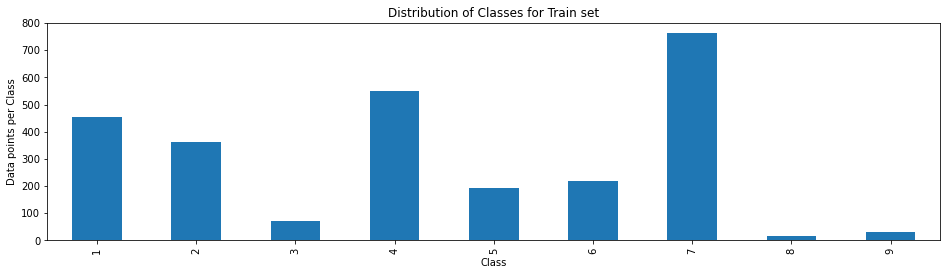

Number of data points in class 7 : 762 ( 22.945 %)
Number of data points in class 4 : 549 ( 16.531 %)
Number of data points in class 1 : 454 ( 13.671 %)
Number of data points in class 2 : 361 ( 10.87 %)
Number of data points in class 6 : 220 ( 6.625 %)
Number of data points in class 5 : 194 ( 5.842 %)
Number of data points in class 3 : 71 ( 2.138 %)
Number of data points in class 9 : 30 ( 0.903 %)
Number of data points in class 8 : 15 ( 0.452 %)


In [20]:
# Training set distribution:
plt.figure(figsize=(16, 4))

class_distribution = xy_train['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes for Train set')
plt.show()
print('='*100)

sorted_class = np.argsort(-class_distribution.values)
for i in sorted_class:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

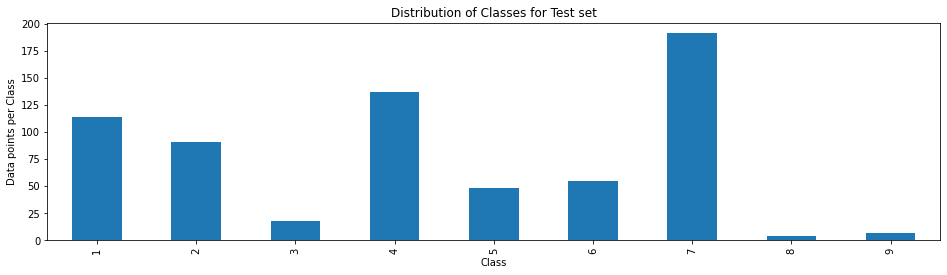

Number of data points in class 7 : 191 ( 5.751 %)
Number of data points in class 4 : 137 ( 4.125 %)
Number of data points in class 1 : 114 ( 3.433 %)
Number of data points in class 2 : 91 ( 2.74 %)
Number of data points in class 6 : 55 ( 1.656 %)
Number of data points in class 5 : 48 ( 1.445 %)
Number of data points in class 3 : 18 ( 0.542 %)
Number of data points in class 9 : 7 ( 0.211 %)
Number of data points in class 8 : 4 ( 0.12 %)


In [21]:
# Test set distribution:

plt.figure(figsize=(16, 4))

class_distribution = xy_test['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes for Test set')
plt.show()
print('='*100)

sorted_class = np.argsort(-class_distribution.values)
for i in sorted_class:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

- Stratify ensures that the distribution of target variable remains the same in both train & test set

# Gene:

In [22]:
genes = xy_train['Gene'].value_counts()
genes1 = len(np.unique(np.array(xy_train["Gene"])))
print('The number of unique Genes in the dataset are:',genes1)
genes.head(10)

The number of unique Genes in the dataset are: 247


BRCA1     211
TP53      127
EGFR      115
PTEN      104
BRCA2      97
BRAF       74
KIT        74
ERBB2      59
ALK        56
PDGFRA     48
Name: Gene, dtype: int64

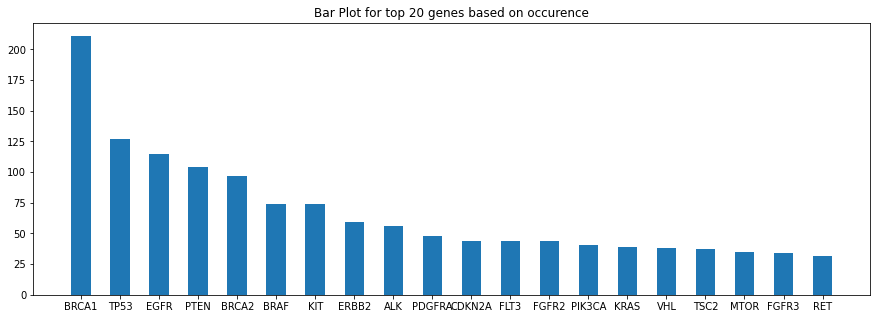

In [23]:
thisdict = (dict(genes))
gene = []
for x in thisdict.keys():
    gene.append(x)

count = []
for y in thisdict.values():
    count.append(y)

plt.figure(figsize=(15, 5))
x_axis = gene[:20]
y_axis = count[:20]
plt.bar(x_axis,y_axis,width = 0.5)
plt.title('Bar Plot for top 20 genes based on occurence')
plt.show()

# Variation:

In [24]:
variation = xy_train['Variation'].value_counts()
variation1 = len(np.unique(np.array(data["Variation"])))
print('The number of unique Variations in the dataset are:',variation1)
variation

The number of unique Variations in the dataset are: 2996


Truncating Mutations    69
Deletion                57
Amplification           57
Fusions                 31
G12V                     4
                        ..
E258V                    1
V559C                    1
R177*                    1
F1761S                   1
E2419K                   1
Name: Variation, Length: 2410, dtype: int64

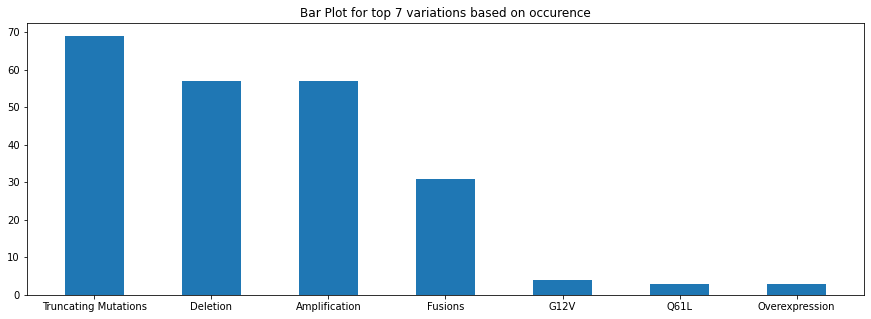

In [26]:
thisdict = (dict(variation))
var = []
for x in thisdict.keys():
    var.append(x)

count = []
for y in thisdict.values():
    count.append(y)

plt.figure(figsize=(15, 5))
x_axis = var[:7]
y_axis = count[:7]
plt.bar(x_axis,y_axis,width = 0.5)
plt.title('Bar Plot for top 7 variations based on occurence')
plt.show()

# Top Gene based on class:

In [71]:
def top_feature_(data,target,feature,class_,top):
    x1 = data.groupby(by = target)
    x2 = x1.get_group(class_)
    x3 = x2[feature].value_counts()
    x4 = list(dict(x3).keys())[:top]
    x5 = list(dict(x3).values())[:top] 
    plt.title('Top {} {} for class {}'.format(top,feature,class_))
    plt.bar(x4,x5,width = 0.2)

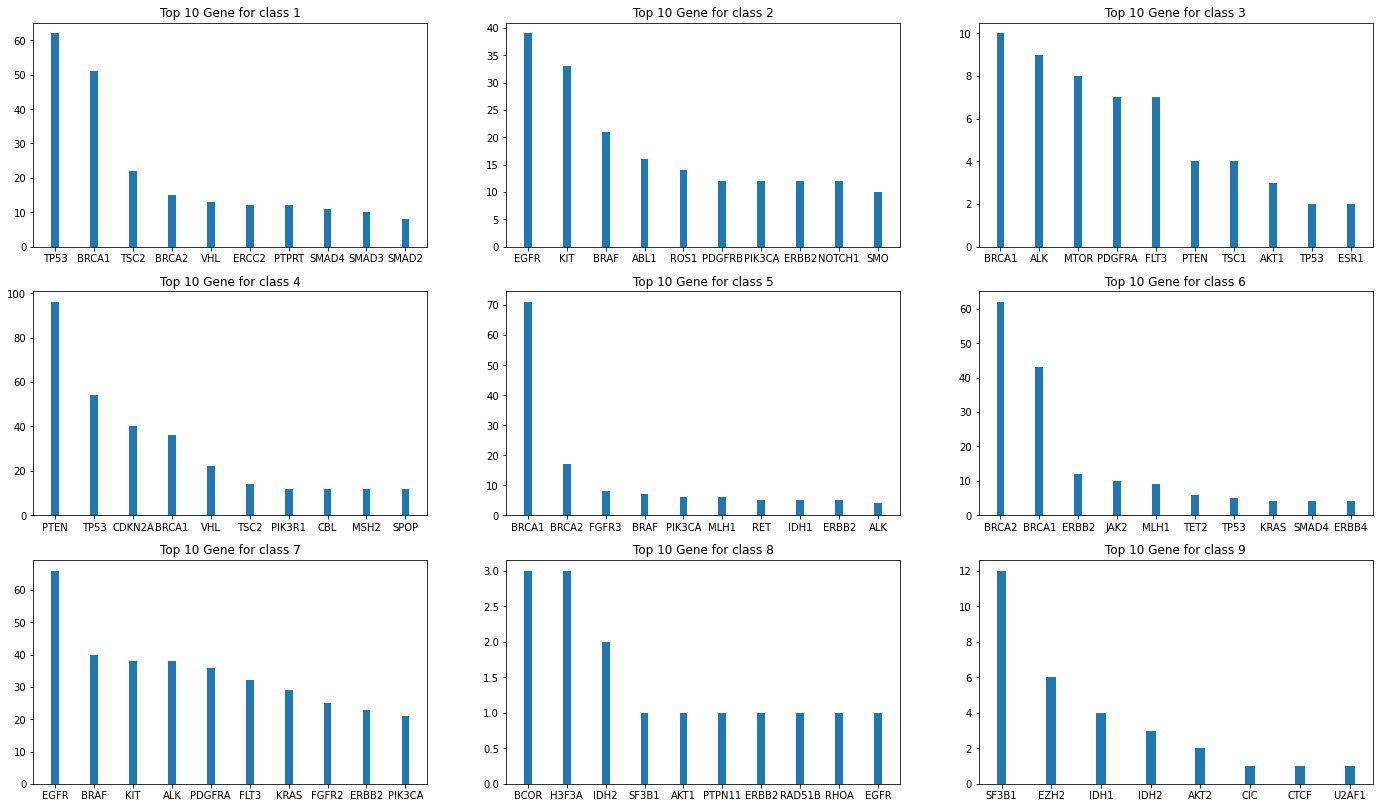

In [72]:
plt.figure(figsize=(24, 14))
plt.subplot(3,3,1)
top_feature_(xy_train,'Class','Gene',1,10)

plt.subplot(3,3,2)
top_feature_(xy_train,'Class','Gene',2,10)

plt.subplot(3,3,3)
top_feature_(xy_train,'Class','Gene',3,10)

plt.subplot(3,3,4)
top_feature_(xy_train,'Class','Gene',4,10)

plt.subplot(3,3,5)
top_feature_(xy_train,'Class','Gene',5,10)

plt.subplot(3,3,6)
top_feature_(xy_train,'Class','Gene',6,10)

plt.subplot(3,3,7)
top_feature_(xy_train,'Class','Gene',7,10)

plt.subplot(3,3,8)
top_feature_(xy_train,'Class','Gene',8,10)

plt.subplot(3,3,9)
top_feature_(xy_train,'Class','Gene',9,10)

# Top Variation based on class:

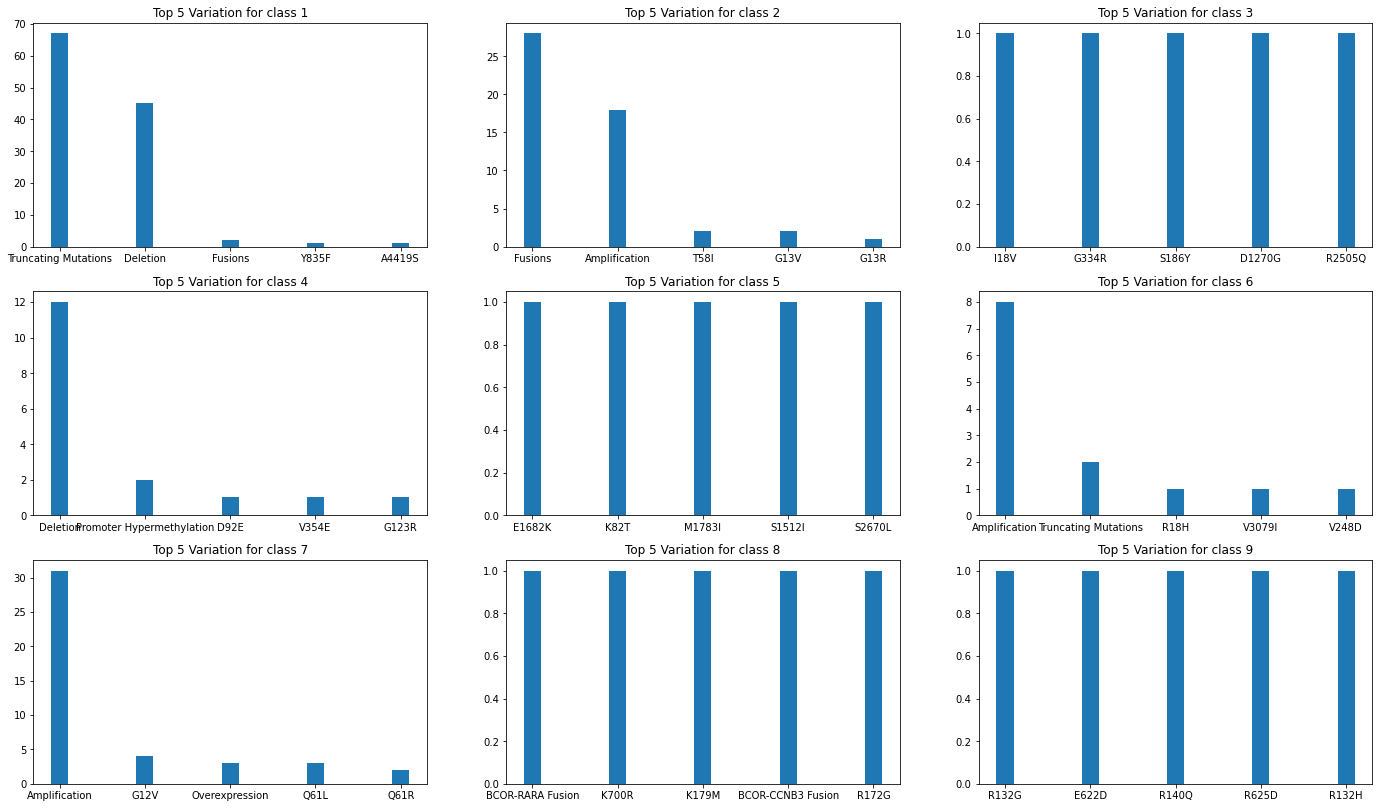

In [76]:
plt.figure(figsize=(24, 14))
plt.subplot(3,3,1)
top_feature_(xy_train,'Class','Variation',1,5)

plt.subplot(3,3,2)
top_feature_(xy_train,'Class','Variation',2,5)

plt.subplot(3,3,3)
top_feature_(xy_train,'Class','Variation',3,5)

plt.subplot(3,3,4)
top_feature_(xy_train,'Class','Variation',4,5)

plt.subplot(3,3,5)
top_feature_(xy_train,'Class','Variation',5,5)

plt.subplot(3,3,6)
top_feature_(xy_train,'Class','Variation',6,5)

plt.subplot(3,3,7)
top_feature_(xy_train,'Class','Variation',7,5)

plt.subplot(3,3,8)
top_feature_(xy_train,'Class','Variation',8,5)

plt.subplot(3,3,9)
top_feature_(xy_train,'Class','Variation',9,5)

# Data Cleaning:

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\PANCHAYAT
[nltk_data]     SAMITI 01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
stop_words.add('also')
stop_words.add('using')
stop_words.add('fig')
stop_words.add('the')
stop_words.add('expression')
stop_words.add('type')
stop_words.add('using')
stop_words.add('we')
stop_words.add('may')
stop_words.add('shown')
stop_words.add('however')
stop_words.add('to')
stop_words.add('these')
stop_words.add('well')

In [19]:
# Cleaning the [TEXT]:

def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters, stop words
    and expands the contracted words and returns words after applying stemming
    
    '''
    sent = text.lower().strip()
    sent = re.sub('[^a-zA-Z]',' ',text)
    sent = sent.split()
    final = [word for word in sent if not word in set(stop_words)]
    final_sent =  ' '.join(final)
    return final_sent

In [20]:
train_text = [] 
for z in tqdm(range(len(xy_train.TEXT.values))):
    r1 = clean((xy_train.TEXT.values[z]))
    train_text.append(r1)


100%|██████████████████████████████████████████████████████████████████████████████| 2656/2656 [01:29<00:00, 29.71it/s]


In [21]:
test_text = [] 
for z in tqdm(range(len(xy_test.TEXT.values))):
    r1 = clean((xy_test.TEXT.values[z]))
    test_text.append(r1)


100%|████████████████████████████████████████████████████████████████████████████████| 665/665 [00:29<00:00, 22.22it/s]


In [22]:
# Adding the cleaned TEXT in the dataset:
xy_train['TEXT'] = train_text
xy_test['TEXT'] = test_text

# Visualization on Text:

In [109]:
def get_top_ngram(corpus, n,count_):
    """
    This function returns a list of tuples, where the first element in tuple is the word 
    and the second element is the frequency of that in the corpus
    
    """
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus) # initialize the countvectorizer
    bag_of_words = vec.transform(corpus) # fitting on the corpus
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()] # list of tuples as mentioned above
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) # sorting the list in descending order, to get 
                                                                       # higher frequency words first.
    return words_freq[:count_] # we return the top 30 grams with high frequency

<AxesSubplot:>

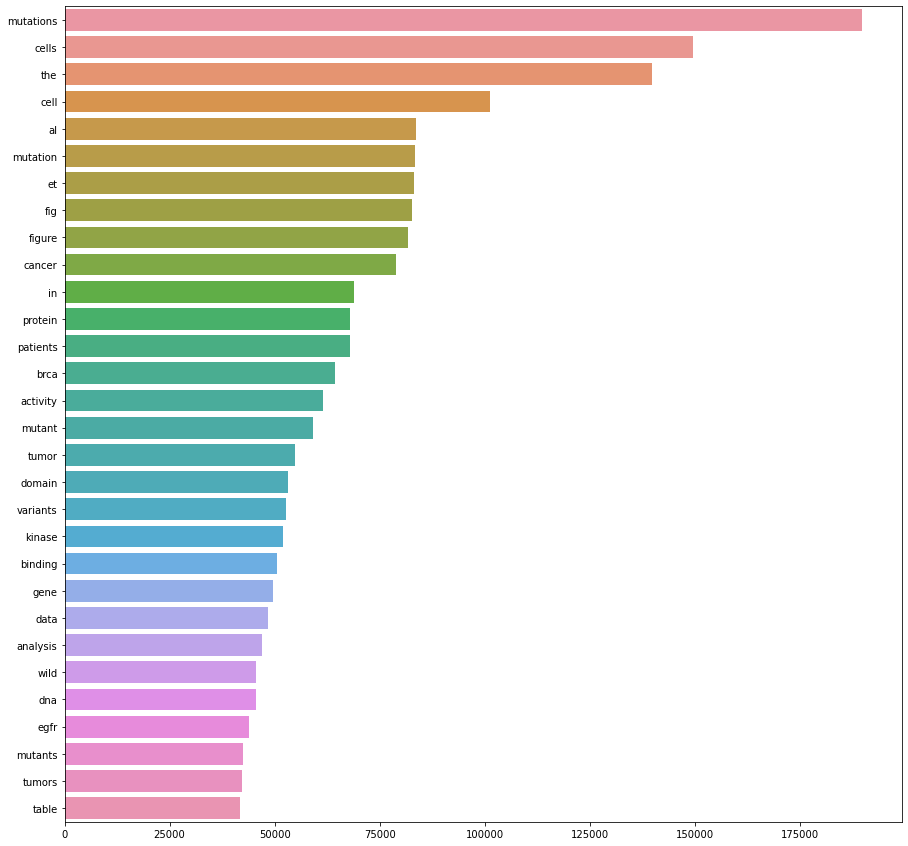

In [110]:
# Here we see the top unigrams
top_n_bigrams=get_top_ngram(xy_train['TEXT'],1,30)

plt.figure(figsize=(15, 15))
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

<AxesSubplot:>

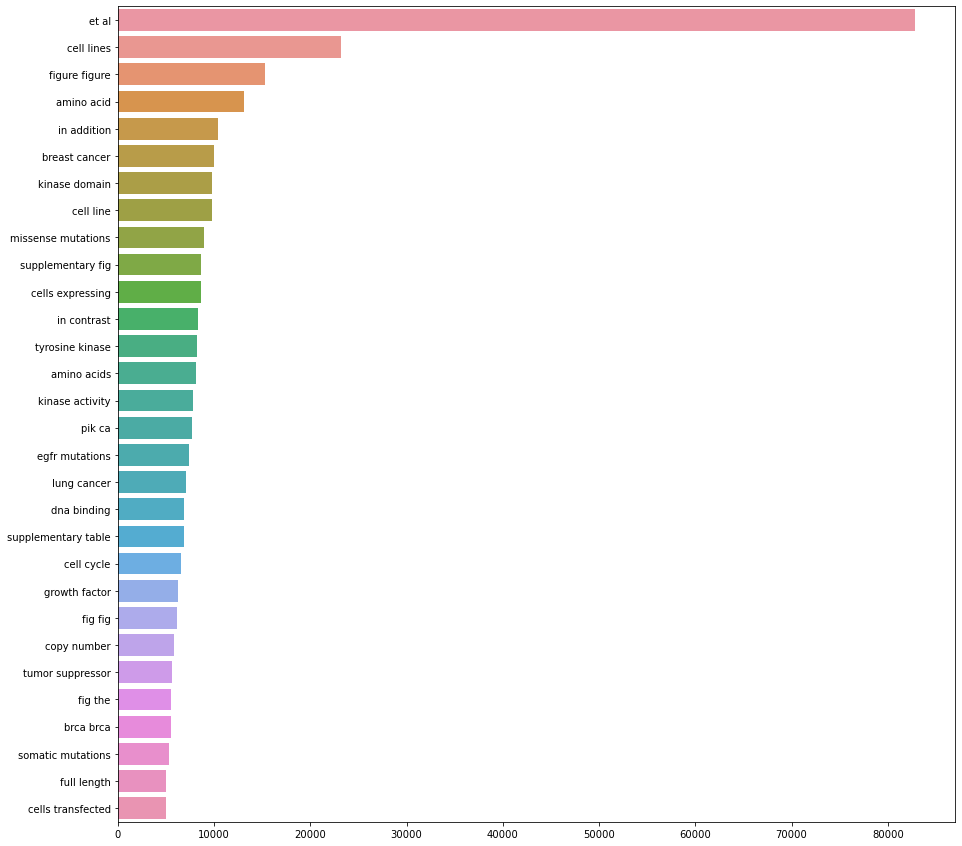

In [105]:
# Here we see the top bi-grams.
top_n_bigrams=get_top_ngram(xy_train['TEXT'],2,30)

plt.figure(figsize=(15, 15))
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

In [134]:
def wordcloud(data,class_):
    x1 = data.groupby(by = "Class")
    x2 = x1.get_group(class_)
    words = ''
    for j in (x2["TEXT"].values[:2]): # This loop extracts words from sentences given to it as input
        c = (str(j).split())
        for v in c:
            b = v.lower()
            words += "".join(b)+" "
    
    wc_q = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10)
    wc_q.generate(words)
    plt.title("Wordcloud for class {}".format(class_), fontsize = 20)
    plt.axis("off")
    plt.imshow(wc_q, interpolation='bilinear')

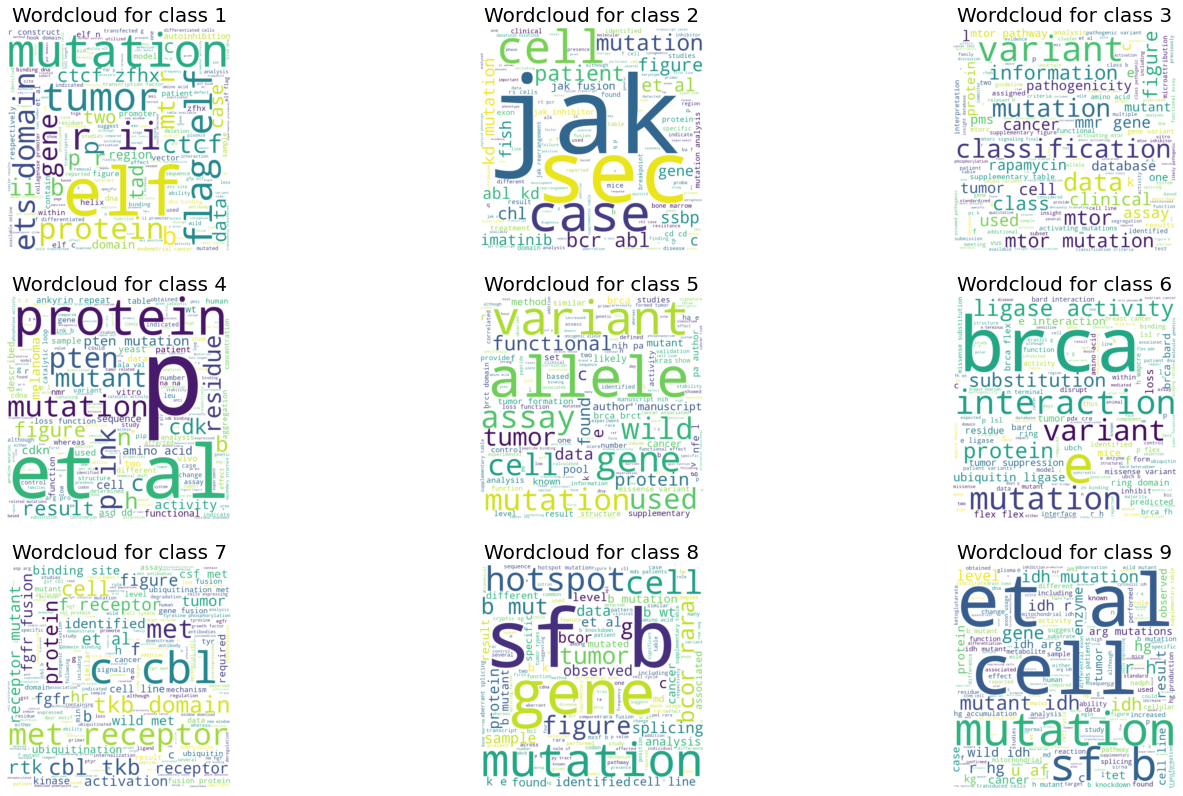

In [135]:
plt.figure(figsize=(24, 14))
plt.subplot(3,3,1)
wordcloud(xy_train,1)

plt.subplot(3,3,2)
wordcloud(xy_train,2)

plt.subplot(3,3,3)
wordcloud(xy_train,3)

plt.subplot(3,3,4)
wordcloud(xy_train,4)

plt.subplot(3,3,5)
wordcloud(xy_train,5)

plt.subplot(3,3,6)
wordcloud(xy_train,6)

plt.subplot(3,3,7)
wordcloud(xy_train,7)

plt.subplot(3,3,8)
wordcloud(xy_train,8)

plt.subplot(3,3,9)
wordcloud(xy_train,9)

# Confusion matrix, Precision,Recall:

In [136]:
def conufsion_precision_recall(y_actual, y_predict):
    '''
    This function plots the confusion matrix, recall & precision
    
    '''
    C = confusion_matrix(y_actual, y_predict)     
    
    precision =(C/C.sum(axis=0)) # dividing each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    # sum of column elements = 1
    
    recall =(((C.T)/(C.sum(axis=1))).T) # dividing each element of the confusion matrix with the sum of elements in that row
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    

    labels = [1,2,3,4,5,6,7,8,9] # since we have 9 classes

    # Confusion Matrix
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(20,5))
    sns.heatmap(precision, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Precision Matrix')
    plt.show()
    
    plt.figure(figsize=(20,5))
    sns.heatmap(recall, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Recall Matrix')
    plt.show()

# Data Preprocessing: 

# CatBoost Encoder:

In [23]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
label = ["Gene","Variation"]

xy_train[label] = cbe_encoder.fit_transform(xy_train[label],y_train)
xy_test[label] = cbe_encoder.transform(xy_test[label],y_test)

In [24]:
xy_train[label].head()

,Gene,Variation
2216,4.367093,4.367093
684,4.367093,4.367093
2549,4.367093,4.367093
2572,4.683547,4.367093
1385,4.367093,4.367093


# TFIDF:

In [25]:
# TF-IDF on TEXT:

tfidf = TfidfVectorizer(min_df=20,ngram_range=(1,3), max_features=1000)

text_train_orignal = tfidf.fit_transform(xy_train['TEXT'].values)
text_test_orignal = tfidf.transform(xy_test['TEXT'].values)

print('After TF-IDF')
print('Original train text data shape',text_train_orignal.shape)
print('='*100)
print('Original test text data shape',text_test_orignal.shape)

After TF-IDF
Original train text data shape (2656, 1000)
Original test text data shape (665, 1000)


In [26]:
text_data = pd.DataFrame(text_train_orignal.toarray())

In [27]:
text_data

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.023910,0.000000,0.000000,0.000000,0.000000,0.040018,0.010790,0.002965,0.000000,...,0.009877,0.000000,0.010158,0.001955,0.001852,0.004467,0.005507,0.000000,0.113270,0.000000
1,0.000000,0.009829,0.000000,0.005680,0.003221,0.006245,0.018597,0.017742,0.000000,0.000000,...,0.009474,0.000000,0.012527,0.012861,0.018271,0.062428,0.009055,0.008509,0.023282,0.005721
2,0.000000,0.016129,0.000000,0.003728,0.003172,0.006149,0.016901,0.010481,0.000000,0.000000,...,0.077291,0.004619,0.016445,0.000000,0.005997,0.007231,0.004458,0.000000,0.005731,0.003755
3,0.000000,0.009454,0.000000,0.002185,0.001859,0.000000,0.009906,0.016382,0.000000,0.000000,...,0.014059,0.000000,0.020885,0.001855,0.005272,0.019073,0.000000,0.000000,0.010077,0.002201
4,0.000000,0.002312,0.008808,0.000000,0.002274,0.011020,0.004039,0.000000,0.000000,0.028772,...,0.005732,0.000000,0.005894,0.000000,0.002149,0.000000,0.000000,0.003003,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,0.000000,0.024451,0.000000,0.000000,0.000000,0.019976,0.009151,0.000000,0.000000,0.004829,...,0.023088,0.000000,0.023744,0.010284,0.006493,0.000000,0.000000,0.000000,0.000000,0.000000
2652,0.016988,0.003820,0.065490,0.013247,0.026296,0.000000,0.016681,0.016551,0.000000,0.000000,...,0.028409,0.000000,0.012985,0.000000,0.017755,0.000000,0.000000,0.000000,0.000000,0.004447
2653,0.000000,0.020393,0.000000,0.003928,0.008355,0.000000,0.000000,0.040493,0.000000,0.007048,...,0.000000,0.000000,0.015884,0.000000,0.000000,0.001905,0.000000,0.002207,0.000000,0.000000
2654,0.007930,0.001783,0.044155,0.004122,0.003507,0.011898,0.000000,0.000000,0.010616,0.002465,...,0.016208,0.000000,0.003031,0.012251,0.000000,0.021987,0.002464,0.009263,0.000000,0.000000


In [31]:
text_data_test = pd.DataFrame(text_test_orignal.toarray())

In [ ]:
xy_train

# Concatenating the features:

In [30]:
xy_train.drop(["ID","TEXT","Class"],axis = 1, inplace = True)
xy_test.drop(["ID","TEXT","Class"],axis = 1, inplace = True)

In [39]:
xy_train = xy_train.reset_index().drop(["index"], axis=1)
xy_test = xy_test.reset_index().drop(["index"], axis=1)

In [43]:
X_train = pd.merge(xy_train,text_data,left_index=True, right_index=True)
X_test = pd.merge(xy_test,text_data_test,left_index=True, right_index=True)


print("Final Data matrix")
print("="*100)
print('Train data shape:',X_train.shape, y_train.shape)
print("="*100)
print('Test data shape:',X_test.shape, y_test.shape)

Final Data matrix
Train data shape: (2656, 1002) (2656,)
Test data shape: (665, 1002) (665,)


# Baseline Models:

# Naive Bayes:

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
 11%|█████████▎                                      

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.35it/s]


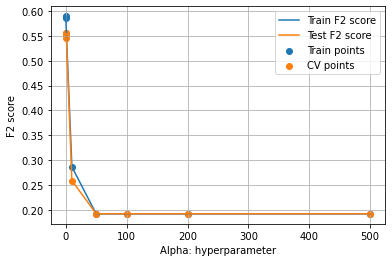

In [45]:
new_train_auc = [] # this stores the training scores
cv_auc = [] # this stores the CV scores

alpha = [0.01,0.05,0.1,1,10,50,100,200,500] # trying different values of alpha to find the best one
for i in tqdm(alpha):
    naive = MultinomialNB(alpha=i)
    naive.fit(X_train, y_train)

    y_newtrain_pred =  naive.predict(X_train)
    y_cv_pred = naive.predict(X_test)
     
    new_train_auc.append(fbeta_score(y_train,y_newtrain_pred,beta = 2,average = 'weighted'))
    cv_auc.append(fbeta_score(y_test,y_cv_pred,beta = 2,average = 'weighted'))

plt.plot(alpha, new_train_auc, label='Train F2 score')
plt.plot(alpha, cv_auc, label='Test F2 score')

plt.scatter(alpha, new_train_auc, label='Train points')
plt.scatter(alpha, cv_auc, label='CV points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("F2 score")
plt.grid()
plt.show()

In [46]:
for i,j in zip(alpha,cv_auc):
    print("For alpha = {}; F2 score = {}".format(i,j))
    

For alpha = 0.01; F2 score = 0.5538516953923448
For alpha = 0.05; F2 score = 0.5549701149906469
For alpha = 0.1; F2 score = 0.5549334747634636
For alpha = 1; F2 score = 0.5458846506820599
For alpha = 10; F2 score = 0.25879591717295614
For alpha = 50; F2 score = 0.19194767885423844
For alpha = 100; F2 score = 0.19194767885423844
For alpha = 200; F2 score = 0.19194767885423844
For alpha = 500; F2 score = 0.19194767885423844


- Best alpha = 0.01

In [47]:
naive_best = MultinomialNB(alpha=0.1)
naive_best.fit(X_train, y_train)
y_newtrain_pred =  naive_best.predict(X_train)
y_cv_pred = naive_best.predict(X_test)
     
test_f2 = (fbeta_score(y_test,y_cv_pred,beta = 2,average = 'weighted'))
print("F2 score = {}".format(test_f2))

F2 score = 0.5549334747634636


C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Random Forest: Hyperparameter tuning

https://github.com/karndeepsingh/optuna/blob/master/Optuna.ipynb

In [48]:
def objective(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    n_estimators = trial.suggest_int("n_estimators", 5,500)
    min_samples_split = trial.suggest_int("min_samples_split", 2,32)

    rf = RandomForestClassifier(criterion =criterion,max_depth=max_depth, n_estimators=n_estimators)

    score = cross_val_score(rf, X_train, y_train, n_jobs=-1, cv=5,scoring = 'f1_weighted')
    accuracy = score.mean()
    return accuracy

In [49]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2022-08-26 15:31:45,897] A new study created in memory with name: no-name-3116fe44-33b1-4a66-8f4b-0450bac8b5c2
[I 2022-08-26 15:32:00,521] Trial 0 finished with value: 0.3352787824208471 and parameters: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 209, 'min_samples_split': 20}. Best is trial 0 with value: 0.3352787824208471.
[I 2022-08-26 15:33:14,192] Trial 1 finished with value: 0.6207212212668549 and parameters: {'criterion': 'entropy', 'max_depth': 87, 'n_estimators': 268, 'min_samples_split': 20}. Best is trial 1 with value: 0.6207212212668549.
[I 2022-08-26 15:34:56,016] Trial 2 finished with value: 0.6208864723592202 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 373, 'min_samples_split': 19}. Best is trial 2 with value: 0.6208864723592202.
[I 2022-08-26 15:35:02,497] Trial 3 finished with value: 0.3314357703557663 and parameters: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 232, 'min_samples_split': 12}. Best is trial 2 with value

In [50]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.629343096378637
Best hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 225, 'min_samples_split': 29}


# Fitting model on best hyperparameters:

In [51]:
rf_best = RandomForestClassifier(n_estimators= 225, min_samples_split= 29, max_depth=15, criterion = 'gini', random_state = 0)
rf_best.fit(X_train,y_train)

rf_train_predict = rf_best.predict(X_train)
rf_test_predict = rf_best.predict(X_test)

train_f2 = (fbeta_score(y_train,rf_train_predict,beta = 2,average = 'weighted'))
test_f2 = (fbeta_score(y_test,rf_test_predict,beta = 2,average = 'weighted'))

print("Train F2 score = {}".format(train_f2))
print("Test F2 score = {}".format(test_f2))

C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Train F2 score = 0.8168885145380644
Test F2 score = 0.6280012315706156


C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
